Intall Tweepy, import libraries and mount the drive. Then you have to log in with your Twitter API credentials.

In [ ]:
%%capture
!pip install tweepy

In [ ]:
import os
import tweepy as tw
import pandas as pd
import json
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
from datetime import datetime, timedelta
import time
import networkx as nx
import re
import pprint
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [ ]:
auth = tw.OAuthHandler("", "")
auth.set_access_token("", "")
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Simple analysis of the tweets gathered in the other notebook

In [ ]:
df_17 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-17-safe_with_mentions.csv", lineterminator='\n')
df_17 = df_17.drop(["Unnamed: 0","Unnamed: 0.1", "Unnamed: 0.1.1","Unnamed: 0.1.1.1"], axis=1)
df_24 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-24-safe.csv", lineterminator='\n')
df = pd.concat([df_17, df_24])
df_individual = df[df["in_reply_to_tweet"].isnull() & df["user_mentions"].isnull()]
df_replies = df[df["in_reply_to_tweet"].notnull()]
df_mentions = df[df["user_mentions"].notnull()]
users = df.user.unique()


print(f'Total tweets: {df.shape[0]}')
print(f'Number of individual tweets are: {df_individual.shape[0]}')
print(f'Number of replies tweets are: {df_replies.shape[0]}')
print(f'Number of mentions tweets are: {df_mentions.shape[0]}')
print(f'Number of users is: {len(users)}')

Total tweets: 90936
Number of individual tweets are: 16147
Number of replies tweets are: 7653
Number of mentions tweets are: 74398
Number of users is: 25385


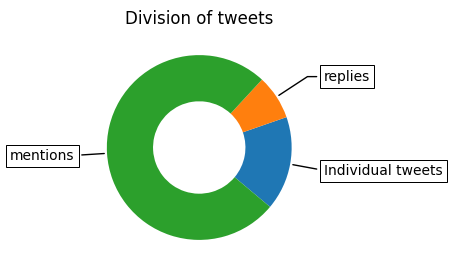

<Figure size 2000x1000 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

labels = ["Individual tweets",
          "replies",
          "mentions"]

data = [int(df_individual.shape[0]), int(df_replies.shape[0]), int(df_mentions.shape[0])]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")


for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
ax.set_title("Division of tweets")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/tweets_data/division.png", dpi=250, format='png')
fig = plt.figure(figsize=(20,10))
plt.show()

In [ ]:
lista_date = df["date"].tolist()
days = []
for el in lista_date:
  date_time_obj = datetime.strptime(el, '%Y-%m-%d %H:%M:%S')
  day = date_time_obj.day
  days.append(day)

a = Counter(days)
print(a)
giorni = []
valori = []

for key in sorted(a.keys()):
  giorni.append(str(key))
  valori.append(a[key])


print(giorni)
print(valori)

Counter({15: 53846, 16: 8155, 14: 4744, 18: 4744, 10: 4108, 9: 3482, 13: 2302, 12: 2232, 21: 1594, 11: 1532, 17: 1468, 23: 758, 8: 755, 22: 600, 19: 344, 24: 171, 20: 101})
['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
[755, 3482, 4108, 1532, 2232, 2302, 4744, 53846, 8155, 1468, 4744, 344, 101, 1594, 600, 758, 171]


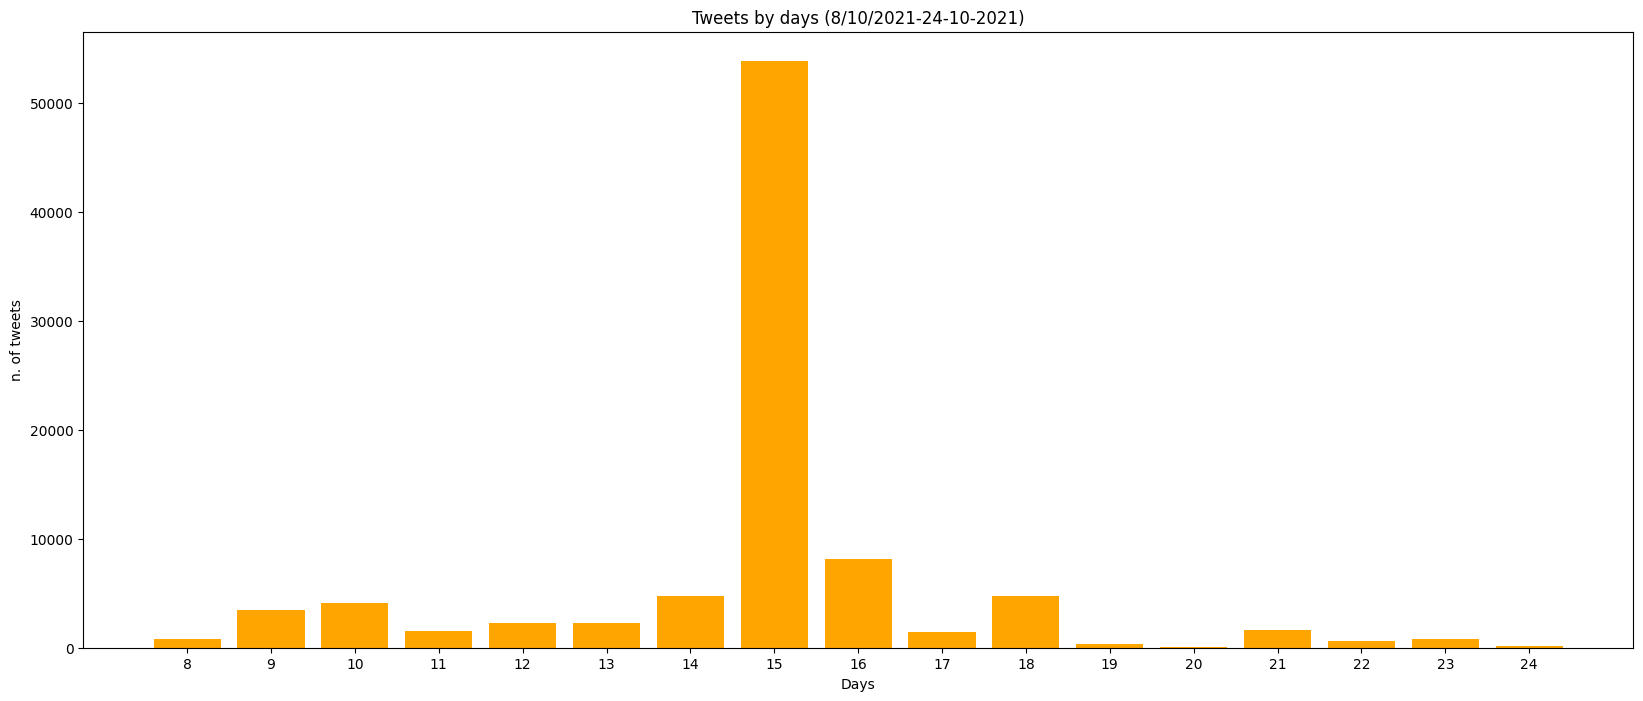

In [ ]:
x = giorni
y = valori
fig = plt.figure(figsize=(20,8))
plt.xlabel('Days')
plt.ylabel('n. of tweets')
plt.title('Tweets by days (8/10/2021-24-10-2021)')
plt.bar(x,y, color=['orange'])
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/tweets_data/days.png", dpi=300, format='png')
plt.show()  

Analyze the result from Gephi. The function below creates a new dataframe that filter data according to our needs. You need to specify the classes (None if you want to consider the whole network), the measure to apply (e.g. 'Degree') and how many top results.

In [ ]:
def gephi_results(data, classes, score, number):
  df_17 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-17-safe_with_mentions.csv", lineterminator='\n')
  df_17 = df_17.drop(["Unnamed: 0","Unnamed: 0.1", "Unnamed: 0.1.1","Unnamed: 0.1.1.1"], axis=1)
  df_24 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-24-safe.csv", lineterminator='\n')
  df = pd.concat([df_17, df_24])
  if classes == None:
    Label = []
    followers = []
    description = []
    verified = []
    df_gephi = pd.read_csv(data)
    print(f'Top {number} popular user by {score} in the whole network:')
    df_gephi = df_gephi.sort_values(by=[score], ascending=False)
    df_gephi = df_gephi.head(number)
    for index, row in df_gephi.iterrows():
      try:
        user = int(row["Id"])
        user = str(user)
        if "." in user:
          tmp = user.split(".")
          user = tmp[0]
        u = api.get_user(user)
        Label.append(u.screen_name)
        followers.append(u.followers_count)
        description.append(u.description)
        verified.append(u.verified)
      except:
        user = int(row["Id"])
        ao = df.loc[df['user'].isin([user])]
        ao = ao.iloc[0]
        Label.append(ao.user_name)
        followers.append(None)
        description.append(ao.user_description)
        verified.append(ao.user_verified)
    df_gephi['Label'] = Label
    df_gephi['verified'] = verified
    df_gephi['followers'] = followers
    df_gephi['description'] = description
    df_gephi = df_gephi[['Id', 'Label', 'verified', 'followers', 'description', 'indegree', 'outdegree', 'Degree', 'weighted indegree', 'weighted outdegree', 'Weighted Degree', 'Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality', 'betweenesscentrality', 'modularity_class', 'Authority', 'Hub',  'timeset']] 
    return df_gephi
  
  else:
    print(f'Top {number} popular user by {score} in class {classes}:')
    Label = []
    followers = []
    description = []
    verified = []
    df_gephi = pd.read_csv(data)
    df_gephi = df_gephi[df_gephi["modularity_class"] == classes]
    df_gephi = df_gephi.sort_values(by=[score], ascending=False)
    df_gephi = df_gephi.head(number)
    for index, row in df_gephi.iterrows():
      try:
        user = int(row["Id"])
        user = str(user)
        if "." in user:
          tmp = user.split(".")
          user = tmp[0]
        u = api.get_user(user)
        Label.append(u.screen_name)
        followers.append(int(u.followers_count))
        description.append(u.description)
        verified.append(u.verified)
      except:
        user = int(row["Id"])
        ao = df.loc[df['user'].isin([user])]
        ao = ao.iloc[0]
        Label.append(ao.user_name)
        followers.append(None)
        description.append(ao.user_description)
        verified.append(ao.user_verified)
    df_gephi['Label'] = Label
    df_gephi['verified'] = verified
    df_gephi['followers'] = followers
    df_gephi['description'] = description
    df_gephi = df_gephi[['Id', 'Label', 'verified', 'followers', 'description', 'indegree', 'outdegree', 'Degree', 'weighted indegree', 'weighted outdegree', 'Weighted Degree', 'Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality', 'betweenesscentrality', 'modularity_class', 'Authority', 'Hub',  'timeset']] 
    return df_gephi





In [ ]:
df_gephi = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv")
classes = df_gephi['modularity_class'].value_counts()[:5].index.tolist() #gets the most 5 popular classes
print(classes)
#df_gephi = df_gephi[df_gephi["modularity_class"] == 209] 
#df_gephi = df_gephi.sort_values(by=['Degree'], ascending=False)
#df_gephi = df_gephi.head(20)
#df_gephi

[74, 11, 403, 336, 393]


In [ ]:
gephi_result = gephi_results("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", 403, 'Authority', 10)
gephi_result = gephi_result.drop(["description",'Id', "indegree", "outdegree", "weighted indegree", "Weighted Degree", "weighted outdegree","Eccentricity", "closnesscentrality", "harmonicclosnesscentrality", "timeset", "modularity_class"], axis=1)

print(gephi_result.to_latex(index=False, caption="Top 10 in community 403 by Authority"))#creates a Latex table

Top 10 popular user by Authority in class 403:
\begin{table}
\centering
\caption{Top 10 in community 403 by Authority}
\begin{tabular}{llrrrrr}
\toprule
           Label &  verified &  followers &  Degree &  betweenesscentrality &  Authority &       Hub \\
\midrule
    Agenzia\_Ansa &      True &  1446456.0 &     264 &              0.000592 &   0.057813 &  0.000641 \\
 MediasetTgcom24 &      True &  1188361.0 &     285 &              0.000706 &   0.052231 &  0.002441 \\
       Adnkronos &      True &   537155.0 &     442 &              0.000864 &   0.048797 &  0.012528 \\
        tempoweb &     False &    82971.0 &     208 &              0.000370 &   0.045925 &  0.004059 \\
      repubblica &      True &  3195270.0 &     328 &              0.001567 &   0.040405 &  0.000321 \\
        Corriere &      True &  2425813.0 &     258 &              0.001182 &   0.024286 &  0.001293 \\
      AlRobecchi &     False &    42953.0 &     119 &              0.000090 &   0.019482 &  0.000001 \\
     

In [ ]:
gephi_results("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", None, 'Degree', 20)

Top 20 popular user by Degree in the whole network:


,Id,Label,verified,followers,description,indegree,outdegree,Degree,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class,Authority,Hub,timeset
396,707022920,pbecchi,False,69246.0,https://t.co/F0Oq2agQ0J,942,580,1522,1398,678,2076,12,0.318216,0.414875,0.004676,74,0.350501,0.005642,NaN
352,16145985,Giorgiolaporta,True,60843.0,Giornalista. Già Portavoce presso la Presidenz...,427,797,1224,494,811,1305,9,0.308679,0.369507,0.003631,74,0.180181,0.009633,NaN
384,700665886823219200,None,None,NaN,None,889,305,1194,1485,375,1860,7,0.395592,0.535281,0.002438,74,0.302660,0.005744,NaN
333,1323040160,strange_days_82,False,6241.0,Amo lo sport. Amo il cinema.Scrivo recensioni ...,638,523,1161,900,613,1513,10,0.317532,0.381470,0.003320,74,0.227056,0.009819,NaN
440,1300873999312982016,eits77,False,63.0,💵 25$ free with https://t.co/rMidZ5b9f3 referr...,958,1,959,959,2,961,0,0.000000,0.000000,0.000000,74,0.176523,0.000000,NaN
662,1288086111806521088,None,None,NaN,None,942,1,943,943,2,945,1,1.000000,1.000000,0.000008,11,0.001840,0.000000,NaN
349,1207268171675324416,ParcodiGiacomo,False,3214.0,Giornalista professionista e scrittore. Già la...,436,477,913,558,528,1086,11,0.329530,0.390750,0.002777,74,0.191209,0.021447,NaN
403,445201884,dottorbarbieri,False,11359.0,"Il conto, per favore. [RT≠Endorsement]",231,608,839,331,726,1057,9,0.306458,0.352324,0.001439,74,0.122524,0.016470,NaN
402,475862409,molumbe,False,21901.0,Italia Libera e Sovrana,727,51,778,894,57,951,4,0.683168,0.832126,0.000377,74,0.239325,0.000098,NaN
369,720690069275807744,Itsmylifemusic1,False,452.0,"Sostenitrice Progetto COEMM, Programma Ⓜ️ondo ...",523,174,697,746,242,988,6,0.357696,0.464042,0.001235,74,0.183619,0.000901,NaN


Textual analysis of users from different comunities (not used in the paper, but still useful)

In [ ]:
def word_cloud(corpus, output):
  wordcloud = WordCloud(width=1920, height=1080, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
  wordcloud.generate(corpus)
  wordcloud.to_image()
  wordcloud.to_file(output + '_wordcloud.png')

def clear_text(text):
  stopwords = nltk.corpus.stopwords.words("italian")
  stopwords.extend(['www', 'org', 'one', 'https', 'F0Oq2agQ0J', 't', 'co', 'già'])
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  words = tokenizer.tokenize(text)
  clean_text = [w for w in words if w.lower() not in stopwords]
  return clean_text

def get_common_words (text, number):
  frequency = nltk.FreqDist(clear_text(text))
  return frequency.most_common(number)

def get_text_analysis(data, classes, score, number):
  df = pd.read_csv(data)
  df = gephi_results(data, classes, score, number)
  df_description = df[df["description"].notnull()]
  df_description = df_description["description"]
  list_descriptions = df_description.tolist()
  df_user = df[df["Id"].notnull()]
  df_user = df_user["Id"]
  list_users = df_user.tolist()
  tweets = []
  for name in list_users:
    try:
      tweets_list= api.user_timeline(int(name), count=100, tweet_mode='extended', exclude_replies= True, include_rts = False)
      for tweet in tweets_list:
        tweets.append(tweet.full_text)
    except tw.TweepError as e: 
        print("Tweepy Error: {}".format(e), name)
        pass
  list_descriptions.extend(tweets)
  text = " ".join(list_descriptions)
  a = clear_text(text)
  a = " ".join(a)
  print(get_common_words(a, 10))
  word_cloud(a, str(classes)+"_"+str(score)+"_"+str(number))

In [ ]:
get_text_analysis("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", 74, 'Degree', 50)
get_text_analysis("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", 11, 'Degree', 50)
get_text_analysis("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", 403, 'Degree', 50)



Top 50 popular user by Degree in class 74:
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 700665886823219200
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1372897890234949632
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1330089541458407424
Tweepy Error: Not authorized. 598603007
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1183975875123073024
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 900766265245130752
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1364939599601168384
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1349326471479885824
Tweepy Error: [{'code': 34, 'message': 'Sorry, that page does not exist.'}] 1428603283531309056
[('Trieste', 141), ('Drittoerovescio', 99), ('Italia', 91), ('pass', 83), ('Draghi', 81), ('Covid', 81), ('solo', 80), ('vaccinati', 72), ('anni', 66),

In [ ]:
gephi = gephi_results("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/gephi_data/gephi_data_final_17_24.csv", None, 'betweenesscentrality', 20)
df_17 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-17-safe_with_mentions.csv", lineterminator='\n')
df_17 = df_17.drop(["Unnamed: 0","Unnamed: 0.1", "Unnamed: 0.1.1","Unnamed: 0.1.1.1"], axis=1)
df_24 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Twitter SNA/Twitter_GP_2021-10-24-safe.csv", lineterminator='\n')
df = pd.concat([df_17, df_24])
gephi = gephi[gephi["Label"].isnull()]
users_search = gephi["Id"].tolist()
print(users_search)

Top 20 popular user by betweenesscentrality in the whole network:
[700665886823219200, 1372897890234949632]
